In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from client import Client
from model import MLP
from utils import utils as uu

In [ ]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'You are using device: {device}')

In [3]:
dataset_dir: Path = Path("femnist")
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
partition_dir = dataset_dir / 'client_data_mappings' / 'fed_natural'

## Training the single client on full dataset

In [4]:
dataset = 'FEMNIST'
alphas = [1.0, 2.0, 3.0, 4.0, 5.0]
report_interval = 2500

# Training Hyperparameters
train_batch_size = 32
num_train_steps = 50000
learning_rate = 0.01
weight_decay = 0.001

In [ ]:
c0 = Client(dir=partition_dir,cid=0,epoch=1,batch=128,workers=4)
train_dataloader = c0.train_loader
test_dataloader = c0.test_loader
print(len(train_dataloader))
print(len(test_dataloader))

### Normal training with client class

In [ ]:
alpha = 0.1
model = MLP(alpha=alpha).to(device)
model.apply(uu.init_weights)

# Training
train_loss_list = []
test_loss_list = []
test_acc_list = []

epoch = 20

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    model.train()

    for data,label in train_dataloader:
        train_loss += c0._train(model,train_dataloader)
    batch_train_loss = train_loss/len(train_dataloader)
    
    model.eval()
    with torch.no_grad():
        for data,label in test_dataloader:
            loss,acc = c0._test(model,test_dataloader)
            test_loss += loss
            test_acc += acc
    batch_test_loss = test_loss/len(test_dataloader)
    batch_test_acc = test_acc/len(test_dataloader)
    print("Train_Loss: {:.4f}".format(batch_train_loss))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)


In [ ]:
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.savefig("images/single_client_loss_plot.png")
plt.show()

### Normal training process

In [ ]:
model = MLP(alpha=0.1).to(device)
model.apply(uu.init_weights)
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
criterion=torch.nn.CrossEntropyLoss()

# Training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

epoch = 20

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    model.train()

    for data,label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        y_pred_prob = model(data)
        loss = criterion(y_pred_prob,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.max(y_pred_prob,1)[1]                        #[1] is indicies of the resulting tensor
        train_acc += torch.sum(y_pred==label).item()/len(label)
    batch_train_loss = train_loss/len(train_dataloader)
    batch_train_acc = train_acc/len(train_dataloader)
    
    model.eval()
    with torch.no_grad():
        for data,label in test_dataloader:
            data = data.to(device)
            label = label.to(device)
            y_pred_prob = model(data)
            loss = criterion(y_pred_prob,label)
            test_loss += loss.item()
            y_pred = torch.max(y_pred_prob,1)[1]
            test_acc += torch.sum(y_pred==label).item()/len(label)
    batch_test_loss = test_loss/len(test_dataloader)
    batch_test_acc = test_acc/len(test_dataloader)
    print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    train_acc_list.append(batch_train_acc)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)


In [ ]:
# visualizing training process
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.savefig("images/model_loss_plot.png")
plt.show()

### Alpha training process

In [9]:
def prune_by_magnitude(percent_to_keep, weight):
    condition = torch.abs(weight.flatten())
    how_many = int(percent_to_keep * torch.numel(condition))
    top_k = torch.topk(condition, k=how_many)
    mask = torch.zeros(condition.shape).to(device)
    mask[top_k.indices] = 1
    return mask.reshape(weight.shape)

def evaluate_pruning(alpha, client, model, test_dataloader):
    final_weights = model.get_weights()
    #print(len(final_weights))
    sparsity_levels = np.geomspace(0.01, 1.0, 20).tolist()
    acc_at_sparsity = []
    for p_to_use in sparsity_levels:
        # Half the sparsity at output layer
        percent = [p_to_use, p_to_use, p_to_use, p_to_use, min(1.0, p_to_use * 2.0)]
        masks = []
        for p, w in zip(percent, final_weights):
            masks.append(prune_by_magnitude(p, w))

        loss, acc = client._test(model, test_dataloader, masks=masks)
        acc_at_sparsity.append(acc)

    return acc_at_sparsity

In [7]:
model_types = []
for alpha in alphas:
    if alpha > 1.0:
        model_types.append('Powerprop:(alpha={})'.format(alpha))
    else:
        model_types.append('Baseline')
print(model_types)

['Baseline', 'Powerprop:(alpha=2.0)', 'Powerprop:(alpha=3.0)', 'Powerprop:(alpha=4.0)', 'Powerprop:(alpha=5.0)']


In [ ]:
model = MLP(alpha=0.1).to(device)
model.apply(uu.init_weights)
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
criterion=torch.nn.CrossEntropyLoss()

repetitions = 5
total_results = []
total_weights = []
for r in range(repetitions):
    round_results = []
    weight_results = []
    for alpha in alphas:
        print(f'Repetion={r}, Alpha={alpha}')
        model = MLP(alpha=alpha).to(device)
        model.apply(uu.init_weights)
        initial_weights = model.get_weights()
        optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        criterion=torch.nn.CrossEntropyLoss()

        uu.train(model, train_dataloader, optimizer, criterion, device, epochs=20)

        final_weights = model.get_weights()

        test_loss, test_acc = c0._test(model, test_dataloader)
        print(f'Test Set [alpha={alpha}]:\tLoss={test_loss:.4f}\tAcc={test_acc:.4f}')

        pruning_accs = evaluate_pruning(alpha, c0, model, test_dataloader)
        round_results.append(pruning_accs)
        weight_results.append((initial_weights, final_weights))
    
    total_results.append(round_results)
    total_weights.append(weight_results)

## Save the results of the alpha training 

In [ ]:
print(len(total_weights))
print(len(total_weights[0]))
print(len(total_weights[0][0]))
print(len(total_weights[0][0][0]))
print(total_weights[0][0][0][0].shape)
weights = []
for i in range(len(total_weights)):
    weight1 = []
    for j in range(len(total_weights[i])):
        weight2 = []
        for k in range(len(total_weights[i][j])):
            layers = []
            for layer in total_weights[i][j][k]:
                layers.append(layer.to("cpu"))
            weight2.append(layers)
        weight1.append(weight2)
    weights.append(weight1)

print(len(weights))
print(len(weights[0]))
print(len(weights[0][0]))
print(len(weights[0][0][0]))
print(weights[0][0][0][0].shape)

np.save(r'./results/femnist0_weights_before_after_epoch20_mlp.npy', np.array(weights))

In [ ]:
np.save(r'./results/femnist0_sparsity_performance_epoch20_mlp.npy', np.array(total_results))
arr = np.array(total_results)
means = arr.mean(axis=0)
stds = arr.std(axis=0)

## Plot the results

In [7]:
import seaborn as sns

### weight remaining and accuracy

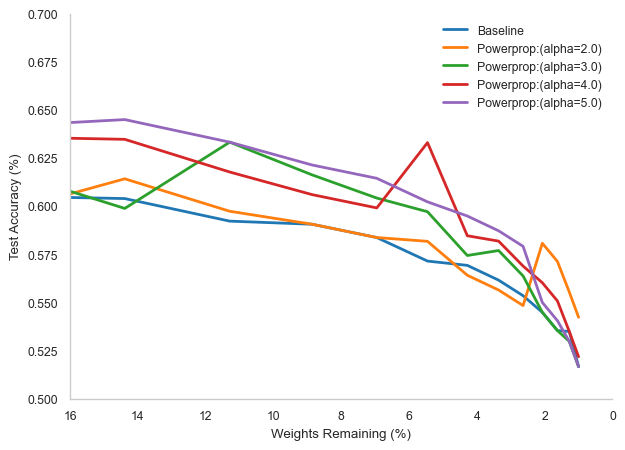

In [106]:
sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = 100 * np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    ax.errorbar(sparsity_levels, means[i], label=label, lw=2)

ax.set_xlim([16, 0.0])
ax.set_ylim([0.5, 0.7])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xlabel('Weights Remaining (%)')
ax.set_ylabel('Test Accuracy (%)')
sns.despine()
f.savefig('images/femnist0_sparsity_performance_epoch20_mlp_grid_off.png')

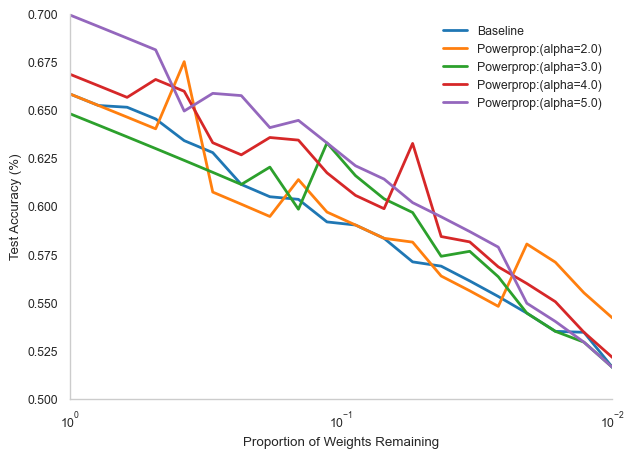

In [105]:
sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    ax.errorbar(sparsity_levels, means[i], label=label, lw=2)

ax.set_xscale('log')
ax.set_xlim([1.0, 0.01])
ax.set_ylim([0.5, 0.7])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xlabel('Proportion of Weights Remaining')
ax.set_ylabel('Test Accuracy (%)')

sns.despine()
f.savefig('images/femnist0_sparsity_performance_log_epoch20_mlp.png')